In [1]:
%load_ext Cython

In [2]:
%%cython -a
import numpy as np
from copy import deepcopy
import cython
from libc.math cimport pi

cdef class InterpXY(object):
    cdef double[:] xs, ys, ks, bs
    cdef int length, n
    def __init__(self, double[:] xs, double[:] ys):
        self.xs = xs
        self.ys = ys
        if len(xs) != len(ys):
            raise AttributeError(f'Длины xs ({len(xs)}) и ys ({len(ys)}) не одинаковы')
        cdef double[:] kv = np.zeros(len(xs), dtype=np.double)
        self.ks = kv
        cdef double[:] bv = np.zeros(len(xs), dtype=np.double)
        self.bs = bv
        self.sync_ks_bs()
        self.n = 0
        
    cpdef double get_v(self, double x):
        cdef double tt = x
        cdef int n = self.set_n(tt)
        if n < 0 or n == (self.length-1) or self.length == 1:
            n = 0 if n<0 else n
            self.n = n
            return self.ys[n]
        self.n = n
        return self.ks[n] * tt + self.bs[n]
        
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef int set_n(self, double t):
        cdef int n = self.n
        if n < 0:
            if self.xs[0] > t:
                return -1
            n = 0
        cdef int minw, maxw;
        cdef int lengthM1 = self.length - 1;
        if self.xs[n] <= t:
            if n == lengthM1 or self.xs[n + 1] > t:
                return n
            n += 1
            if n == lengthM1 or self.xs[n + 1] > t:
                return n
            if self.xs[self.length-1] <= t:
                return lengthM1
            minw = n
            maxw = lengthM1
        else:
            if n == 0 or self.xs[n - 1] <= t:
                return n-1
            if self.xs[0] > t:
                n = -1
                return n
            minw = 0
            maxw = n
        while minw != maxw:
            n = (minw + maxw) // 2
            if self.xs[n] <= t:
                if self.xs[n + 1] > t:
                    return n
                minw = n
            else:
                maxw = n
        n = minw
        return n
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void sync_ks_bs(self):
        self.length = len(self.xs)
        cdef size_t i
        for i in range(self.length):
            self.ks[i] = (self.ys[i + 1] - self.ys[i]) / (self.xs[i + 1] - self.xs[i])
            self.bs[i] = self.ys[i] - self.ks[i] * self.xs[i]


def get_opts_sample():
    """
    Функция для получения примера опций для DirectBall
    """
    return {
        'powder': {
            'I_k': 0.32,      # импульс конца горения МПа*с
            'alpha_k': 1.008, # коволюм
            'ro': 1.6,        # плотность пороха г/см^3   
            'f': 1.027,       # сила пороха, МДж/кг
            'etta': 0.228,    # k -1
            'T_1': 3006.0     # темп. горения ?
        },
        'init_cond': {
            'omega': 23,      # масса навески пороха, г
            'd':23,           # калибр, мм      
            'K_zar': 1.08,    # коэфф, учитывающий доп работы
            'q': 190,         # масса снаряда, г
            'delta': 800,     # плотность заряжания, кг/м^3
            'sigma_T': 376,   # Постоянная коэффициента теплоотдачи, Дж*м/кг*К*с
            'v_T': 0.7,       # Относительная разность температур
            'p0': 5e6,        # Давление вспышки, Па
            'p_f': 60e6       # Давление форсирования, Па
        },
        'integr_cond': {
            'l_max': 0.887,   # длина ствола
            't_max': 0.5,     # на всякий пожарынй
            'dt': 6e-6        # шаг по времени
        }
    }


cdef class DirectBall(object):
    """
    Решение прямой задачи внутренней баллистики с 1 порохом
    """
    cdef public dict opts
    
    cdef double I_k,alpha_k,ro,omega,S,d,fi,q,F_0,delta,f,k,R_g,v_T,sigma_T,p_f,p0,l_max,t_max,dt
    cdef InterpXY dpsi_dz
    
    def __init__(self, opts, dpsidz, z):
        self.opts = deepcopy(opts)
        self.dpsi_dz = InterpXY(z, dpsidz)
        
    def get_y0(self):
        return np.array([self.p0, 0, self.omega/self.delta-self.omega/self.ro, 0, 0, 0])
      
    @cython.boundscheck(False)
    @cython.wraparound(False)  
    def run(self):
        """
        return np.array((много, 6))
        res[i] = [t, p, l, W, V, psi, z]
        
        чтобы сделать слайс для:
            t res[:,0]
            p res[:,1]
            l res[:,2]
            W res[:,3]
            V res[:,4]
            psi res[:,5]
            z res[:,6]
        """
        self.init_consts()
        cdef double[:] y = self.get_y0()
        cdef list ys = []
        cdef list ts = []
        cdef double[:] k1,k2,k3,k4,yn1
        k1 = np.empty_like(y)
        k2 = np.empty_like(y)
        k3 = np.empty_like(y)
        k4 = np.empty_like(y)       
        cdef double t = 0.0, dt = self.dt        
        cdef int i,j
        while True:
            ys.append(y)
            ts.append(t)
            if t >= self.t_max or y[3] >= self.l_max:
                break
            self.get_dydt(t, y, k1)
            self.get_dydt(t+0.5*dt, self.euler_step(0.5*dt, y, k1), k2)
            self.get_dydt(t+0.5*dt, self.euler_step(0.5*dt, y, k2), k3)
            self.get_dydt(t+dt, self.euler_step(dt, y, k3), k4)
            yn1 = np.empty_like(y)
            for i in range(len(yn1)):
                yn1[i] = y[i] + (k1[i]+2*k2[i]+2*k3[i]+k4[i])*dt/6
            t += dt
            y = yn1
        res = np.zeros((len(ts), len(y)+1), dtype=np.double)
        for i in range(len(ts)):
            y = ys[i]
            t = ts[i]
            res[i,0] = t 
            for j in range(len(y)):
                res[i,j+1] = y[j]
        return res

    @cython.boundscheck(False)
    @cython.wraparound(False)  
    cpdef double[:] euler_step(self, double dt, double[:] y, double[:] dy):
        cdef double[:] res = np.empty_like(y)
        cdef int i
        for i in range(len(y)):
            res[i] = y[i] + dt*dy[i]
        return res
   
    cpdef void init_consts(self):
        powder = self.opts['powder']
        self.I_k = powder['I_k'] * 10**6
        self.alpha_k = powder['alpha_k']/10**3
        self.ro = powder['ro']*10**3
        self.f = powder['f']*10**6
        self.k = powder['etta']+1
        self.R_g = self.f / powder['T_1']
        
        init_cond = self.opts['init_cond']
        self.omega = init_cond['omega'] / 10**3
        self.d = init_cond['d'] / 10**3
        self.S = pi*self.d**2 / 4
        self.q = init_cond['q']/10**3
        self.fi = init_cond['K_zar'] + 1/3 * self.omega / self.q
        self.delta = init_cond['delta']
        self.F_0 = 4 * self.omega / self.delta / self.d
        self.v_T = init_cond['v_T']
        self.sigma_T = init_cond['sigma_T']        
        self.p0 = init_cond['p0']
        self.p_f = init_cond['p_f']
        
        integr_cond = self.opts['integr_cond']
        self.l_max = integr_cond['l_max']
        self.t_max = integr_cond['t_max']
        self.dt = integr_cond['dt']
    
    @cython.boundscheck(False)
    @cython.wraparound(False)    
    cdef void get_dydt(self, double t, double[:] y, double[:] res):
        cdef double p = y[0]

        cdef double l = y[1]
        cdef double W = y[2]
        cdef double V = y[3]
        
        cdef double psi = y[4]
        cdef double z = y[5]
        
        cdef double dz = p/self.I_k
        
        if psi > 1:
            psi = 1
            dz = 0
        elif psi < 0:
            psi = 0
                
        cdef double dpsi = self.get_dpsi(z, dz) if 0 <= psi <= 1 else 0
        cdef double dW = (1-self.alpha_k * self.ro)/self.ro*self.omega*dpsi + self.S*V
        cdef double dV = self.S*p/self.fi/self.q * self.p_f_foo(p, V)
        cdef double F = self.F_0 + pi*l*self.d
        cdef double dp = (self.f*self.omega*dpsi \
                        - (self.k-1)*self.v_T*self.sigma_T*F*p/self.R_g \
                        - self.k*p*dW)/W
        res[0] = dp
        res[1] = V
        res[2] = dW
        res[3] = dV
        res[4] = dpsi
        res[5] = dz
        
    def get_dydt_tst(self, t, y):
        """
        d[p,l,W,V,psi,z]/dt
        """
        cdef double[:] res = np.empty_like(y)
        self.get_dydt(t, y, res)
        return np.asarray(res)
    
    cdef int p_f_foo(self, double p, double V):
        if V > 1e-6:
            return 1
        if p < self.p_f:
            return 0
        return 1
    
    cdef double get_dpsi(self, double z, double dzdt):
        return self.dpsi_dz.get_v(z) * dzdt
#         cdef double k1=0.811, k2=0.505, l1=0.081, l2=-1.024
#         cdef double res = k1*(1+2*l1*z) if z<=1 else k2*(1+2*l2*(z-1)) if z<1.488 else 0
#         return res*dz
            
def get_dpsi_array(k1=0.811, k2=0.505, l1=0.081, l2=-1.024, z_k=1.488, n=1000):
    """
    k1=0.811, k2=0.505, l1=0.081, l2=-1.024, z_k=1.488, n=1000
    return dpsidz, zs
    """
    zs = np.linspace(0, z_k, n)
    dpsidz = np.empty_like(zs)
    for i, z in enumerate(zs):
        dpsidz[i] = k1*(1+2*l1*z) if z<=1 else k2*(1+2*l2*(z-1)) if z<1.488 else 0
    return dpsidz, zs



def get_optsmany_sample():
    """
    Функция для получения примера опций для DirectBallMany
    """
    dpsidz1, zs1 = get_dpsi_array()
    dpsidz2, zs2 = get_dpsi_array(k1=0.653, k2=0.65, l1=0.247, l2=-0.791, z_k=1.602, n=1000)
    return {
        'powders': [
            {
                'omega': 13,      # масса навески пороха, г
                'I_k': 0.32,      # импульс конца горения МПа*с
                'alpha_k': 1.008, # коволюм
                'ro': 1.6,        # плотность пороха г/см^3   
                'f': 1.027,       # сила пороха, МДж/кг
                'etta': 0.228,    # k -1
                'T_1': 3006.0,    # темп. горения ?
                'zs': zs1,        # точки z для интерполяции dpsi_dz
                'dpsi_dz': dpsidz1# точки dpsi_dz для интерполяции dpsi_dz
            },
            {
                'omega': 10,      # масса навески пороха, г
                'I_k': 0.3,       # импульс конца горения МПа*с
                'alpha_k': 1.053, # коволюм
                'ro': 1.6,        # плотность пороха г/см^3   
                'f': 0.988,       # сила пороха, МДж/кг
                'etta': 0.24,     # k -1
                'T_1': 2736.0,    # темп. горения ?
                'zs': zs2,        # точки z для интерполяции dpsi_dz
                'dpsi_dz': dpsidz2# точки dpsi_dz для интерполяции dpsi_dz
            }
        ],
        'init_cond': {
            'd':23,           # калибр, мм      
            'K_zar': 1.08,    # коэфф, учитывающий доп работы
            'q': 190,         # масса снаряда, г
            'W_kam': 28.75,   # объем каморы, см^3
            'sigma_T': 376,   # Постоянная коэффициента теплоотдачи, Дж*м/кг*К*с
            'v_T': 0.7,       # Относительная разность температур
            'p0': 5e6,        # Давление вспышки, Па
            'p_f': 60e6       # Давление форсирования, Па
        },
        'integr_cond': {
            'l_max': 0.887,   # длина ствола
            't_max': 0.5,     # на всякий пожарынй
            'dt': 6e-6        # шаг по времени
        }
    }

cdef class DirectBallMany(object):
    """
    Решение прямой задачи внутренней баллистики с несколькоими порохами
    """
    cdef public dict opts
    cdef public list dpsi_dz_s
    cdef double[:] I_ks,alpha_ks,ros,omegas, fs, T_1s, ks
    
    cdef double S,d,fi,q,F_0,k,R_g,v_T,sigma_T,p_f,p0,l_max,t_max,dt, omega, W_kam
    cdef int n_powders
    
    def __init__(self, opts_many):
        self.opts = deepcopy(opts_many)
        
    def get_y0(self):
        """
        p,  l, W, V, psi1, z1, psi2, z2, ..., psiN, zN
        """
        cdef double w0_sv = self.W_kam
        cdef int i
        for i in range(self.n_powders):
            w0_sv -= self.omegas[i]/self.ros[i]
        res = np.zeros(4+2*self.n_powders)
        res[0] = self.p0
        res[2] = w0_sv
        return res
      
    @cython.boundscheck(False)
    @cython.wraparound(False)  
    def run(self):
        """
        return np.array()
        res[i] = [t, p,  l, W, V, psi1, z1, psi2, z2, ..., psiN, zN]
        
        чтобы сделать слайс для:
            t res[:,0]
            p res[:,1]
            l res[:,2]
            W res[:,3]
            V res[:,4]
            psi1 res[:,5]
            z1 res[:,6]
            ...
            psiN res[:,5+N]
            zN res[:,6+N]
        """
        self.init_consts()
        cdef double[:] y = self.get_y0()
        # [p,  l, W, V, psi1, z1, psi2, z2, ..., psiN, zN]
        # [0,  1, 2, 3,    4,  5,    6,  7, ...,  3+N, 4+N]
        cdef list ys = []
        cdef list ts = []
        cdef double[:] k1,k2,k3,k4,yn1
        k1 = np.empty_like(y)
        k2 = np.empty_like(y)
        k3 = np.empty_like(y)
        k4 = np.empty_like(y)       
        cdef double t = 0.0, dt = self.dt        
        cdef int i,j
        while True:
            ys.append(y)
            ts.append(t)
            if t >= self.t_max or y[1] >= self.l_max:
                break
            self.get_dydt(t, y, k1)
            self.get_dydt(t+0.5*dt, self.euler_step(0.5*dt, y, k1), k2)
            self.get_dydt(t+0.5*dt, self.euler_step(0.5*dt, y, k2), k3)
            self.get_dydt(t+dt, self.euler_step(dt, y, k3), k4)
            yn1 = np.empty_like(y)
            for i in range(len(yn1)):
                yn1[i] = y[i] + (k1[i]+2*k2[i]+2*k3[i]+k4[i])*dt/6
            t += dt
            y = yn1
        res = np.zeros((len(ts), len(y)+1), dtype=np.double)
        for i in range(len(ts)):
            y = ys[i]
            t = ts[i]
            res[i,0] = t 
            for j in range(len(y)):
                res[i,j+1] = y[j]
        return res

    @cython.boundscheck(False)
    @cython.wraparound(False)  
    cpdef double[:] euler_step(self, double dt, double[:] y, double[:] dy):
        cdef double[:] res = np.empty_like(y)
        cdef int i
        for i in range(len(y)):
            res[i] = y[i] + dt*dy[i]
        return res
   
    cpdef void init_consts(self):
        self.n_powders = len(self.opts['powders'])
        self.dpsi_dz_s = []
        self.I_ks = np.zeros(self.n_powders, dtype=np.double) 
        self.alpha_ks = np.zeros(self.n_powders, dtype=np.double) 
        self.ros = np.zeros(self.n_powders, dtype=np.double) 
        self.omegas = np.zeros(self.n_powders, dtype=np.double) 
        self.fs = np.zeros(self.n_powders, dtype=np.double) 
        self.T_1s = np.zeros(self.n_powders, dtype=np.double) 
        self.ks = np.zeros(self.n_powders, dtype=np.double) 
        cdef int i
        for i in range(self.n_powders):
            p = self.opts['powders'][i]
            self.I_ks[i] = p['I_k']* 10**6
            self.alpha_ks[i] = p['alpha_k']/10**3
            self.ros[i] = p['ro']*10**3
            self.omegas[i] = p['omega']/ 10**3
            self.fs[i] = p['f']*10**6
            self.T_1s[i] = p['T_1']
            self.ks[i] = p['etta']+1
            self.dpsi_dz_s.append(InterpXY(p['zs'], p['dpsi_dz']))
            
        self.omega = sum(self.omegas)
        self.k = 0.0
        cdef double T_1 = 0.0
        cdef double f_sred = 0.0
        cdef double ves = 0.0
        for i in range(self.n_powders):
            ves = self.omegas[i]/self.omega
            self.k += ves * self.ks[i]
            T_1 += ves * self.T_1s[i]
            f_sred += ves * self.fs[i]
        self.R_g = f_sred / T_1
        
        init_cond = self.opts['init_cond']
        self.d = init_cond['d'] / 10**3
        self.S = pi*self.d**2 / 4
        self.q = init_cond['q']/10**3
        self.W_kam = init_cond['W_kam']/100**3
        self.fi = init_cond['K_zar'] + 1/3 * self.omega / self.q
        self.F_0 = 4 * self.W_kam / self.d
        self.v_T = init_cond['v_T']
        self.sigma_T = init_cond['sigma_T']        
        self.p0 = init_cond['p0']
        self.p_f = init_cond['p_f']
        
        integr_cond = self.opts['integr_cond']
        self.l_max = integr_cond['l_max']
        self.t_max = integr_cond['t_max']
        self.dt = integr_cond['dt']
    
    @cython.boundscheck(False)
    @cython.wraparound(False)    
    cdef void get_dydt(self, double t, double[:] y, double[:] res):
        # [p,  l, W, V, psi0, z0, psi1, z1, ..., psiN, zN]
        # [0,  1, 2, 3,    4,  5,    6,  7, ...,  4+N, 5+N]
        cdef double p = y[0]
        cdef double psi_i, z_i
        cdef int i
        for i in range(self.n_powders):
            psi_i = y[4+2*i]
            if psi_i > 1.0 or psi_i < 0.0:
                # dz_i
                res[5+2*i] = 0.0
                # dpsi_i
                res[4+2*i] = 0.0
                continue
            z_i = y[5+2*i]
            # dz_i
            res[5+2*i] = p / self.I_ks[i]
            # dpsi_i
            res[4+2*i] = self.dpsi_dz_s[i].get_v(z_i) * res[5+2*i]
        
        
        cdef double l = y[1]
        cdef double W = y[2]
        cdef double V = y[3]
        
        cdef double dW = self.S*V
        cdef double dV = self.S*p/self.fi/self.q * self.p_f_foo(p, V)
        cdef double F = self.F_0 + pi*l*self.d
        cdef double dp = -(self.k-1)*self.v_T*self.sigma_T*F*p/self.R_g
        cdef double dpsi
        for i in range(self.n_powders):
            dpsi = res[4+2*i]
            dW += (1-self.alpha_ks[i] * self.ros[i])/self.ros[i]*self.omegas[i]*dpsi
            dp += self.fs[i]*self.omegas[i]*dpsi
        dp -= self.k*p*dW
        dp /= W
        
        res[0] = dp
        res[1] = V
        res[2] = dW
        res[3] = dV
        
    def get_dydt_tst(self, t, y):
        """
        d[p,psi,z,l,W,V]/dt
        """
        cdef double[:] res = np.empty_like(y)
        self.get_dydt(t, y, res)
        return np.asarray(res)
    
    cdef int p_f_foo(self, double p, double V):
        if V > 1e-6:
            return 1
        if p < self.p_f:
            return 0
        return 1
    
    cdef double get_dpsi(self, double z, double dzdt):
        return self.dpsi_dz.get_v(z) * dzdt
#         cdef double k1=0.811, k2=0.505, l1=0.081, l2=-1.024
#         cdef double res = k1*(1+2*l1*z) if z<=1 else k2*(1+2*l2*(z-1)) if z<1.488 else 0
#         return res*dz

In [7]:
%%cython -a

import numpy as np

cdef double [:,:] somf(int n, int m):
    return np.zeros((n,m))

def foo():
    cdef double [:,:] r = somf(3,4)
    print(r[1,1])

In [8]:
foo()

0.0


In [48]:
23*10**-3/800*100**3

28.75

In [49]:
import numpy as np

xs = np.linspace(-1,10,1000)
ys = np.sin(xs)
ys[:100] = 0.5
ys[-100:] = 0

interp = InterpXY(xs[200:-200],ys[200:-200])
xs2 = np.linspace(-2,11,10000)
ys2 = np.zeros_like(xs2)
for i in range(len(ys2)):
    ys2[i] = interp.get_v(xs2[i])

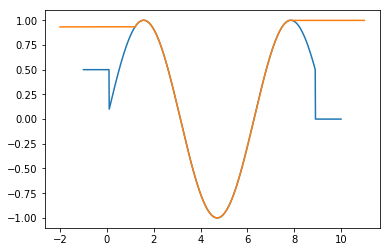

In [50]:
from matplotlib import pyplot as plt

plt.plot(xs, ys)
plt.plot(xs2, ys2)
plt.show()

In [51]:
np.zeros(3)

array([0., 0., 0.])

In [52]:
get_opts_sample()

{'powder': {'I_k': 0.32,
  'alpha_k': 1.008,
  'ro': 1.6,
  'f': 1.027,
  'etta': 0.228,
  'T_1': 3006.0},
 'init_cond': {'omega': 23,
  'd': 23,
  'K_zar': 1.08,
  'q': 190,
  'delta': 800,
  'sigma_T': 376,
  'v_T': 0.7,
  'p0': 5000000.0,
  'p_f': 60000000.0},
 'integr_cond': {'l_max': 0.887, 't_max': 0.5, 'dt': 6e-06}}

In [60]:
optsm = get_optsmany_sample()
optsm['powders'][1] = deepcopy(optsm['powders'][0])
optsm['powders'][0]['omega'] = 10

In [61]:
d_many = DirectBallMany(optsm)

In [62]:
res = d_many.run()
print(d_many.run.__doc__)


        return np.array()
        res[i] = [t, p,  l, W, V, psi1, z1, psi2, z2, ..., psiN, zN]
        
        чтобы сделать слайс для:
            t res[:,0]
            p res[:,1]
            l res[:,2]
            W res[:,3]
            V res[:,4]
            psi1 res[:,5]
            z1 res[:,6]
            ...
            psiN res[:,5+N]
            zN res[:,6+N]
        


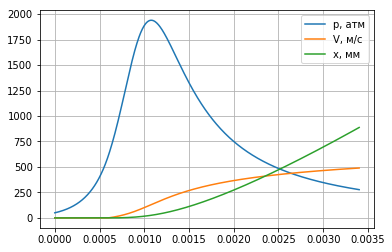

In [63]:
plt.plot(res[:,0], res[:,1]/10**5,label='p, атм')
plt.plot(res[:,0], res[:,4],label='V, м/с')
plt.plot(res[:,0], res[:,2]*1000,label='x, мм')

plt.grid()
plt.legend()
plt.show()

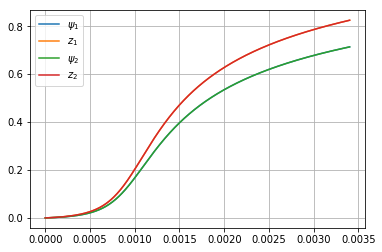

In [64]:
plt.plot(res[:,0], res[:,5],label='$\psi_1$')
plt.plot(res[:,0], res[:,6],label='$z_1$')
plt.plot(res[:,0], res[:,7],label='$\psi_2$')
plt.plot(res[:,0], res[:,8],label='$z_2$')
plt.grid()
plt.legend()
plt.show()

In [65]:
d2 = DirectBall(get_opts_sample(), *get_dpsi_array())

d [p,psi,z,l,W,V] / dt

In [66]:
d2.run?

In [67]:
res2 = d2.run()

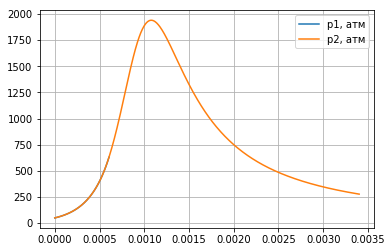

In [68]:
from matplotlib import pyplot as plt

plt.plot(res2[:,0], res2[:,1]/10**5,label='p1, атм')
plt.plot(res[:,0], res[:,1]/10**5,label='p2, атм')
# plt.plot(res2[:,0], res2[:,6],label='V, м/с')
# plt.plot(res2[:,0], res2[:,4]*1000,label='x, мм')
plt.grid()
plt.legend()
plt.show()

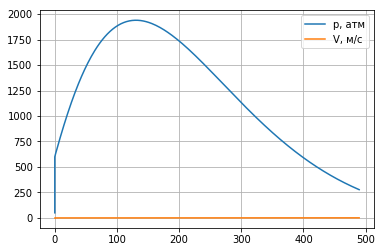

In [69]:
plt.plot(res[:,4], res[:,1]/10**5,label='p, атм')
plt.plot(res[:,4], res[:,6],label='V, м/с')
plt.grid()
plt.legend()
plt.show()

In [121]:
#euler
%timeit d.run()

4.97 ms ± 362 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
#rk4
%timeit d.run()

12.9 ms ± 83.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
